# Example 1: Training the Diffusion Model

In this example, we will train the Variational Diffusion Model (VDM) step-by-step, following the training script `train.py`.

In [1]:
import os
import sys

# replace this with the path to the nehod_torch repository
sys.path.append('/mnt/home/tnguyen/projects/nehod_torch')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Step 1: read and preprocess the data

In this step, we read and preprocess the input data. The data can be found in `example/data` and are already divided into a training and validation set. For each flag (train or validation), the data is further subdivided into:

- `*_example_cond.csv`: A CSV file with the conditional parameters for each example. This includes the halo properties, central galaxy properties, and the simulation parameters (WDM mass and 3 astrophysical parameters).
- `*_example.npz`: A NumPy file with the point cloud data for the satellite galaxies. This includes the positions, velocities, total and stellar masses, and the concentration proxy of each satellite galaxy.

Most of the input/output reading is handled by the `datasets.py` module, which is separate from the `nehod` library. This module is responsible for reading the data, preprocessing it, and returning it in a format that can be used by the training script.

For simplicity, we will only read in the WDM mass ($m_\mathrm{WDM}$), astrophysical parameters ($A_\mathrm{SN1}$, $A_\mathrm{SN2}$, $A_\mathrm{AGN}$), and the number of satellites $N_\mathrm{sat}$ as the conditional parameters. The point cloud data will be read in as is.

In [2]:
# copy of datasets.read_dataset
def read_dataset(data_root, data_name, flag=None, conditioning_parameters=None):
    """ Read a dataset """
    if flag is not None:
        data_name = flag + '_' + data_name
    data = np.load(os.path.join(data_root, f'{data_name}.npz'))
    cond_table = pd.read_csv(os.path.join(data_root, f'{data_name}_cond.csv'))
    if conditioning_parameters is not None:
        cond_table = cond_table[conditioning_parameters]
    return data, cond_table

# Read in data and conditioning parameters
conditioning_parameters = [
    'inv_wdm_mass', 'log_sn1','log_sn2','log_agn1', 'log_num_subhalos']
train_data, train_cond = read_dataset(
    'data', 'example', 'train', conditioning_parameters=conditioning_parameters)
val_data, val_cond = read_dataset(
    'data', 'example', 'val', conditioning_parameters=conditioning_parameters)

### Now let's examine the data features

The `data` will include the following arrays: 
- `features`: features of the satellites, shape `(N, 50, 9)`, where `N` is the number of training (validation) simulations. The second and third dimensions are the *maximum* number of satellites and the features of each satellite. The features are:
    - 3 spatial coordinates
    - 3 velocity components
    - 1 total mass
    - 1 stellar mass
    - 1 concentration proxy

**IMPORTANT**: The number of satellites is not fixed and can vary from simulation to simulation. Thus, to efficiently handle the dataset, we apply zero-paddiong to the data to a fixed number of satellites. The maximum number of satellites is set to 50 for the TNG-WDM dataset in DREAMS. In practice, the VDM can handle any number of satellites. During training, the model will ignore the padding points.

- `mask`: padding mask, 1 if the point is real, 0 if it is a padding point. See above.

- `position_encoding`: ignored, not used in this work

Number of satellites: 21
Conditioning parameters:
- inv_wdm_mass: 0.32
- log_sn1: 0.25
- log_sn2: 1.14
- log_agn1: -0.45
- log_num_subhalos: 1.32


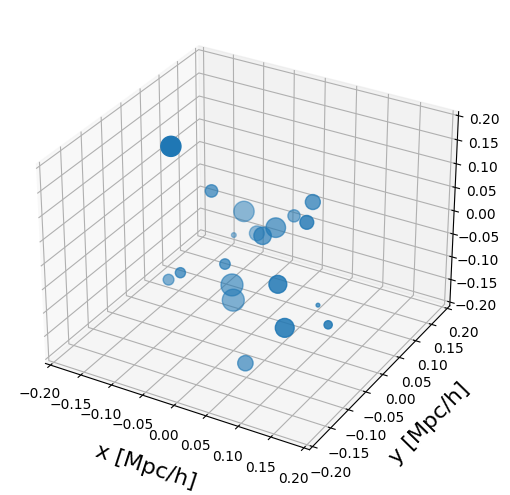

In [3]:
# plot an example satellite
# get the x, y, z coordinates and log_mstar
example = train_data['features'][0]
example_mask = train_data['mask'][0].astype(bool)
example_cond = train_cond.iloc[0]

x, y, z = example[example_mask, 0], example[example_mask, 1], example[example_mask, 2]
log_mstar = example[example_mask, 7]
def scale(x):
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    return (x - x_min) / (x_max - x_min)

print('Number of satellites:', example_mask.sum())
print('Conditioning parameters:')
for k, v in example_cond.to_dict().items():
    print(f'- {k}: {v:.2f}')

# plot the example satellite with the size of the points proportional to log_mstar
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=scale(log_mstar) * 250)
ax.set_xlabel('x [Mpc/h]', fontsize=16, labelpad=10)
ax.set_ylabel('y [Mpc/h]', fontsize=16, labelpad=10)
ax.set_zlabel('z [Mpc/h]', fontsize=16, labelpad=10)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.2)
fig.tight_layout()
plt.show()

### Quick data preprocessing

For data preprocessing, we will simply normalize both the features and conditions to have zero mean and unit variance.

In [4]:
def normalize(data, cond, norm_dict=None):
    # quick function to normalize the data
    x = data['features']
    cond = cond.values  # extract the values from the pandas dataframe
    mask = data['mask'].astype(bool)

    # if norm_dict is None, calculate the mean and std
    if norm_dict is None:
        x_mean = np.mean(x, axis=(0, 1), where=mask[..., None])
        x_std = np.std(x, axis=(0, 1), where=mask[..., None])
        cond_mean = np.mean(cond, axis=0)
        cond_std = np.std(cond, axis=0)
        norm_dict = {
            'x_mean': x_mean,
            'x_std': x_std,
            'cond_mean': cond_mean,
            'cond_std': cond_std
        }
    else:
        x_mean = norm_dict['x_mean']
        x_std = norm_dict['x_std']
        cond_mean = norm_dict['cond_mean']
        cond_std = norm_dict['cond_std']

    # normalize the data
    x = (x - x_mean) / x_std
    cond = (cond - cond_mean) / cond_std
    return x, cond, mask, norm_dict

# normalize the data
# note that both the training and validation data are normalized using the mean and std of the training data
train_data_norm, train_cond_norm, train_mask, norm_dict = normalize(train_data, train_cond)
val_data_norm, val_cond_norm, val_mask, _ = normalize(val_data, val_cond, norm_dict)

In [5]:
# as a final step, we will also need to invert the training mask
# this is due to the differences in the convention used by Pytorch and Jax
# for Jax, the mask is False for padded values (i.e., like how we have it here)
# for Pytorch, the mask is True for padded values
train_mask = ~train_mask
val_mask = ~val_mask

In [6]:
# Finally, we will convert the data to Pytorch tensors and create a DataLoader
import torch
from torch.utils.data import DataLoader, TensorDataset

# convert the data to Pytorch tensors
train_data_norm = torch.tensor(train_data_norm, dtype=torch.float32)
train_cond_norm = torch.tensor(train_cond_norm, dtype=torch.float32)
train_mask = torch.tensor(train_mask, dtype=torch.bool)
val_data_norm = torch.tensor(val_data_norm, dtype=torch.float32)
val_cond_norm = torch.tensor(val_cond_norm, dtype=torch.float32)
val_mask = torch.tensor(val_mask, dtype=torch.bool)

# create a DataLoader with a batch size of 64
train_dataset = TensorDataset(train_data_norm, train_cond_norm, train_mask)
val_dataset = TensorDataset(val_data_norm, val_cond_norm, val_mask)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Before we proceed with the training, note that all of the above steps are already implemented in the `datasets.py` module. 
The syntax for reading and preprocessing the data is as follows:

```python
train_data_norm, train_cond_norm, train_mask, norm_dict = datasets.read_preprocess_dataset(
    data_root='data', data_name='example', conditioning_parameters=conditioning_parameters,
    flag='train', invert_mask=True, norm_dict=None)
val_data_norm, val_cond_norm, val_mask, _ = datasets.read_preprocess_dataset(
    data_root='data', data_name='example', conditioning_parameters=conditioning_parameters,
    flag='val', invert_mask=True, norm_dict=norm_dict)
```

## Step 2: Define the model

In this step, we define the VDM model. The full implementation, including the noise scheduler and the noise prediction network, is complex and can be found in `nehod` library. Here, we will create a simplify version of the model for demonstration purposes.

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist

import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers

from nehod import noise_schedules, scores
from nehod import diffusion_utils, train_utils, augmentations
from nehod.diffusion_utils import alpha, sigma2, variance_preserving_map

As an example, we will show how the forward diffusion process works using the variance-preserving mapping between the data and noise at each diffusion step.

In [8]:
# create the noise scheduler
# for simplicity, we will use a fixed linear schedule
# the noise scheduler takes in the diffusion time, from 0 to 1, and returns the noise level
class NoiseScheduleFixedLinear(nn.Module):
    """ Linear schedule for diffusion variance """
    def __init__(self, gamma_min=-6.0, gamma_max=6.0):
        super().__init__()
        self.gamma_min = torch.tensor(gamma_min, dtype=torch.float32)
        self.gamma_max = torch.tensor(gamma_max, dtype=torch.float32)

    def forward(self, t):
        return self.gamma_max + (self.gamma_min - self.gamma_max) * t

In [9]:
# Take a few example data 
x = train_data_norm[:100, :, 6]  # only take the log mhalo
mask = train_mask[:100]
eps = torch.randn_like(x)  # create a noise tensor

n_timestep = 5
gamma_min, gamma_max = -6.0, 6.0
noise_scheduler = NoiseScheduleFixedLinear(gamma_min, gamma_max)
x_noisy = []
for t in torch.linspace(0, 1, n_timestep):
    gamma = torch.full_like(x, noise_scheduler(t))
    x_noisy.append(variance_preserving_map(x, gamma, eps))

Text(0, 0.5, 'Density')

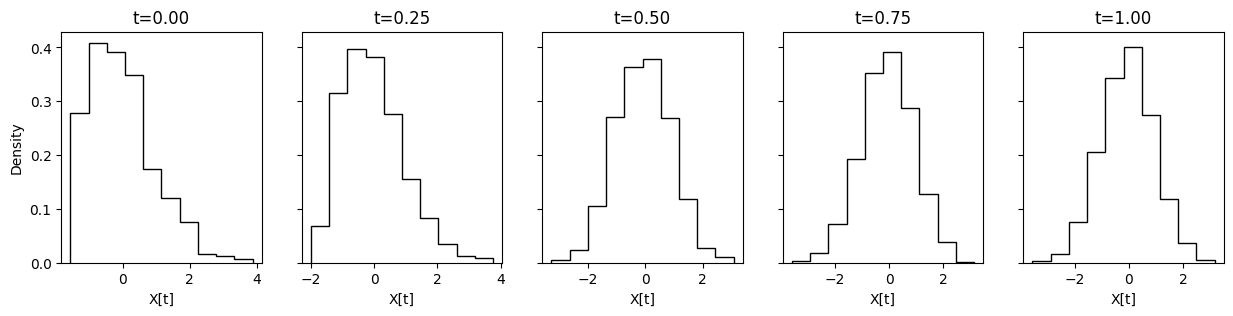

In [10]:
# Plot the clean vs noisy data for a few timesteps
fig, axes = plt.subplots(1, n_timestep, figsize=(3*n_timestep, 3), sharey=True)

for i in range(n_timestep):
    x_plot = x_noisy[i]
    x_plot[mask] = np.nan
    ax = axes[i]
    t = (i) / (n_timestep-1)
    ax.hist(x_plot.ravel(), histtype='step', color='k', linewidth=1, density=True)
    ax.set_xlabel('X[t]')
    ax.set_title(f't={t:.2f}')

axes[0].set_ylabel('Density')

As we go from $t=0$ (clean data) to $t=1$ (noisy data), we see how the satellite mass distribution changes from the exponential distribution to a more Gaussian distribution. 

The loss function for the VDM is the Evidence Lower Bound (ELBO), which is defined as:

\begin{align}
    - \log p(x) \leq -\mathrm{ELBO}(x) 
    = &- \mathbb{E}_{q(z_{1} | x)}\left[D_\mathrm{KL}\left(q(z_{1} | x) \| p(z_{1})\right)\right] \\ 
    &+ \mathbb{E}_{q(z_{0} | x)}\left[\log p(x | z_{0})\right] \\
    &+ \mathcal{L}_\mathrm{diff}(x),
\end{align}

where the diffusion loss $\mathcal{L}_\mathrm{diff}(x)$ is defined as:

\begin{equation}
    \mathcal{L}_\mathrm{diff}(x) = 
    \frac{1}{2} \mathbb{E}_{\epsilon \sim \mathcal{N}(0, \mathbf{I}), t \sim U(0, 1)}
    \left[\gamma'(t) \| \epsilon - \hat{\epsilon}_\varphi(z_{t}, t)\|^2_2
    \right].
\end{equation}

Here $z_t$ is the data at diffusion time $t$, with $t=0$ being the clean data and $t=1$ being the noisy data, $x$ is the input data ($x=z_0$), $\epsilon$ is the noise, and $\hat{\epsilon}_\varphi(z_{t}, t)$ is the noise prediction by the noise-prediction model.
$\gamma(t)$ is the noise level at time $t$, and $\gamma'(t)$ is the time derivative of the noise level.

The diffusion loss consists of three terms:
- The prior matching loss, which minimizes the discrepancy between the final latent distribution and the Gaussian prior.
- The reconstruction loss, which ensures the accuracy between the data and its reconstruction from the latent variable.
- The consistency loss between the forward and reverse diffusion processes. This essentially ensures that the noise prediction model is able to predict the noise level at each diffusion step.

In [11]:
def latent_loss(x, gamma_fn, device=None):
    """ KL divergence between posterior and prior. Prior matching term.

    Parameters
    ----------
    x : The data.
    gamma_fn: The noise scheduler. 
    """
    g_1 = gamma_fn(torch.tensor([1.0], device=device))
    var_1 = sigma2(g_1)
    mean1_sqr = (1 - var_1) * torch.square(x)
    loss_klz = 0.5 * (mean1_sqr + var_1 - torch.log(var_1) - 1.0)
    return loss_klz

def recon_loss(x, gamma_fn, device=None):
    """ Compute the reconstruction loss. Defined as the negative log-likelihood
    of the data under the model.

    Parameters
    ----------
    x : The data.
    gamma_fn: The noise scheduler.
    """
    g_0 = gamma_fn(torch.tensor([0.0], device=device))
    eps_0 = torch.randn_like(x)
    z_0 = variance_preserving_map(x, g_0, eps_0)
    z_0_rescaled = z_0 / alpha(g_0)
    loss_recon = -dist.Normal(loc=z_0_rescaled, scale=1e-3).log_prob(x)
    return loss_recon

def diffusion_loss(t, x, gamma_fn, score_model, cond=None, mask=None, timesteps=0, device=None):
    """ Compute the diffusion loss.

    Parameters
    ----------
    t : The diffusion time.
    x : The data.
    gamma_fn: The noise scheduler.
    cond : The conditioning data.
    mask : The mask for padded data.
    timesteps : The number of diffusion timesteps. Set to 0 for continuous time.
    """
    # Sample z_t
    g_t = gamma_fn(t)
    eps = torch.randn_like(x)
    z_t = variance_preserving_map(x, g_t[:, None], eps)

    # Compute predicted noise and the MSE
    eps_hat = score_model(z_t, g_t, cond, mask)
    deps = eps - eps_hat
    loss_diff_mse = torch.square(deps)  # Compute MSE of predicted noise

    if timesteps == 0:
        # Loss for infinite depth T, i.e. continuous time
        g_t_grad = torch.autograd.grad(
            g_t, t,
            grad_outputs=torch.ones_like(g_t),
            create_graph=True,
            retain_graph=True,
        )[0]
        loss_diff = -0.5 * g_t_grad[:, None, None] * loss_diff_mse
    else:
        # Loss for finite depth T, i.e. discrete time
        s = t - (1.0 / timesteps)
        g_s = gamma_fn(s)
        loss_diff = 0.5 * timesteps * torch.expm1(g_s - g_t)[:, None, None] * loss_diff_mse
    return loss_diff

Now we define the diffusion model. We will use Pytorch Lightning to handle the training. Training is done by optimized the ELBO loss using Gradient Descent. Using Pytorch Lightning syntax, we define the model with the training and validation steps, and the Gradient Descent optimizer.

In [12]:
# Define a diffusion model with a Transformer-based noise model
class DiffusionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # define the noise scehduler
        self.gamma_fn = noise_schedules.NoiseScheduleScalar(-16.0, 10.0)

        # define the score model
        # note that since we are using context embedding
        self.score_model = scores.TransformerScoreModel(
            9,  # number of generated features
            d_cond=16,  # number of conditioning features
            d_t_embedding=16, 
            score_dict=dict(
                d_model=256, d_mlp=512, n_layers=6, n_heads=4
            )
        )

        # context embedding
        self.embedding = nn.Linear(5, 16)

    def _sample_timesteps(self, batch_size, timesteps):
        t0 = torch.rand(batch_size)
        t_n = torch.remainder(
        t0 + torch.arange(0.0, 1.0, step=1.0 / batch_size), 1.0)

        # discretize time steps if we're working with discrete time
        if timesteps > 0:
            t_n = torch.ceil(t_n * timestels) / timesteps

        return t_n

    def forward(self, x, conditioning=None, mask=None, timesteps=0):
        # forward pass
        batch_size = x.shape[0]

        # 1. Reconstruction loss
        loss_recon = recon_loss(x, self.gamma_fn, device=self.device)

        # 2. Latent loss
        loss_klz = latent_loss(x, self.gamma_fn, device=self.device)

        # 3. Diffusion loss
        t = self._sample_timesteps(batch_size, timesteps).requires_grad_(True)
        t = t.to(self.device)
        cond = self.embedding(conditioning)
        loss_diff = diffusion_loss(
            t, x, self.gamma_fn, self.score_model, 
            cond, mask, timesteps, device=x.device)

        return loss_recon, loss_klz, loss_diff

    def prepare_batch(self, batch):
        # Convienence function to prepare the batch
        x, conditioning, mask = batch

        # move to the same device as the model
        x = x.to(self.device)
        conditioning = conditioning.to(self.device)
        mask = mask.to(self.device)

        # data augmentation step
        # apply rotational augmentations to the data by rotating the 3D positions
        # and 3D velocities by a random angle
        x = augmentations.augment_with_symmetries(x, 3, 3, device=self.device)

        return {
            'x': x,
            'conditioning': conditioning,
            'mask': mask,
            'batch_size': x.shape[0],
        }

    def vdm_loss(self, x, conditioning=None, mask=None):
        # Conviencence function to compute the loss
        loss_diff, loss_klz, loss_recon= self.forward(x, conditioning, mask)

        if mask is None:
            mask = torch.ones(x.shape[:-1])
        else:
            # reverse mask because of torch convention
            mask = torch.logical_not(mask).type_as(x)
        loss_batch = (
            ((loss_diff + loss_klz + loss_recon) * mask[:, :, None]).sum((-1, -2))
        ) / mask.sum(-1)
        return loss_batch.mean()

    def training_step(self, batch, batch_idx):
        # Training step, this is required by PyTorch Lightning
        batch_dict = self.prepare_batch(batch)
        loss = self.vdm_loss(
            batch_dict['x'], batch_dict['conditioning'], batch_dict['mask'])
        self.log(
            'train_loss', loss, on_step=True, on_epoch=True,
            batch_size=batch_dict['batch_size'])
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation step, this is required by PyTorch Lightning
        batch_dict = self.prepare_batch(batch)
        with torch.enable_grad():
            # need to enable grad for the score model
            loss = self.vdm_loss(
                batch_dict['x'], batch_dict['conditioning'], batch_dict['mask'])
        self.log(
            'val_loss', loss, on_step=True, on_epoch=True,
            batch_size=batch_dict['batch_size'])
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)
        return optimizer

## Step 3: Training

Once the model is defined, we can start training the VDM.

In [20]:
pl.seed_everything(52)


# Initialize the model
model = DiffusionModel()

# Define callbacks function, including early stopping, model checkpointing, and learning rate monitoring
callbacks = [
    pl.callbacks.EarlyStopping(
        monitor='val_loss', patience=100,
        mode='min', verbose=True),
    pl.callbacks.ModelCheckpoint(
        filename="{epoch}-{val_loss:.4f}", monitor='val_loss',
        save_top_k=3, mode='min', save_weights_only=False,
        save_last=True),
    pl.callbacks.LearningRateMonitor("step"),
]
# logger to save the training logs, this should work even if you don't have tensorboard installed
# alternatively, you can use pl_loggers.WandbLogger to log the results to Weights & Biases
# or pl_loggers.CSVLogger to save the logs to a CSV file
train_logger = pl_loggers.TensorBoardLogger('output/vdm', version='')

# Define a PyTorch Lightning Trainer, which will handle the entire training process
trainer = pl.Trainer(
    default_root_dir='output/vdm',
    max_steps=10_000,  # maximum number of training steps   
    accelerator='gpu',  # remove if running on CPU
    callbacks=callbacks,
    logger=train_logger,
    enable_progress_bar=True,
    inference_mode=False,
    val_check_interval=100,
    check_val_every_n_epoch=None,
    log_every_n_steps=50,
)

# train the model
trainer.fit(
    model, train_loader, val_loader,
    ckpt_path=None
)

Seed set to 52
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory output/vdm/lightning_logs/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | gamma_fn    | NoiseScheduleScalar   | 2     
1 | score_model | TransformerScoreModel | 3.3 M 
2 | embedding   | Linear                | 96    
------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.090    Total estimated model params size (MB)


Epoch 1:  54%|█████▍    | 7/13 [00:00<00:00, 21.89it/s]                    

Metric val_loss improved. New best score: 201.317


Epoch 3:   8%|▊         | 1/13 [00:00<00:00, 22.94it/s] 

Metric val_loss improved by 5.757 >= min_delta = 0.0. New best score: 195.560


Epoch 6:  15%|█▌        | 2/13 [00:00<00:00, 22.69it/s] 

Metric val_loss improved by 4.765 >= min_delta = 0.0. New best score: 190.795


Epoch 7:  69%|██████▉   | 9/13 [00:00<00:00, 23.37it/s] 

Metric val_loss improved by 1.029 >= min_delta = 0.0. New best score: 189.766


Epoch 12:  31%|███       | 4/13 [00:00<00:00, 22.74it/s] 

Metric val_loss improved by 8.653 >= min_delta = 0.0. New best score: 181.113


Epoch 15:  38%|███▊      | 5/13 [00:00<00:00, 21.66it/s] 

Metric val_loss improved by 4.683 >= min_delta = 0.0. New best score: 176.430


Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 22.16it/s]

Metric val_loss improved by 0.755 >= min_delta = 0.0. New best score: 175.675


Epoch 23:   8%|▊         | 1/13 [00:00<00:00, 20.71it/s] 

Metric val_loss improved by 3.216 >= min_delta = 0.0. New best score: 172.459


Epoch 26:  15%|█▌        | 2/13 [00:00<00:00, 25.88it/s] 

Metric val_loss improved by 4.232 >= min_delta = 0.0. New best score: 168.227


Epoch 30:  77%|███████▋  | 10/13 [00:00<00:00, 24.36it/s]

Metric val_loss improved by 5.001 >= min_delta = 0.0. New best score: 163.226


Epoch 33:  85%|████████▍ | 11/13 [00:00<00:00, 24.25it/s]

Metric val_loss improved by 2.267 >= min_delta = 0.0. New best score: 160.960


Epoch 36:  92%|█████████▏| 12/13 [00:00<00:00, 24.38it/s]

Metric val_loss improved by 8.511 >= min_delta = 0.0. New best score: 152.449


Epoch 41:  54%|█████▍    | 7/13 [00:00<00:00, 24.09it/s] 

Metric val_loss improved by 5.552 >= min_delta = 0.0. New best score: 146.897


Epoch 47:  69%|██████▉   | 9/13 [00:00<00:00, 24.21it/s] 

Metric val_loss improved by 2.014 >= min_delta = 0.0. New best score: 144.883


Epoch 53:  85%|████████▍ | 11/13 [00:00<00:00, 24.36it/s]

Metric val_loss improved by 4.247 >= min_delta = 0.0. New best score: 140.635


Epoch 59: 100%|██████████| 13/13 [00:00<00:00, 24.66it/s]

Metric val_loss improved by 1.113 >= min_delta = 0.0. New best score: 139.523


Epoch 63:   8%|▊         | 1/13 [00:00<00:00, 22.76it/s] 

Metric val_loss improved by 0.605 >= min_delta = 0.0. New best score: 138.917


Epoch 64:  62%|██████▏   | 8/13 [00:00<00:00, 24.36it/s] 

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 138.694


Epoch 67:  69%|██████▉   | 9/13 [00:00<00:00, 47.55it/s] 

Metric val_loss improved by 6.568 >= min_delta = 0.0. New best score: 132.126


Epoch 69:  23%|██▎       | 3/13 [00:00<00:00, 48.06it/s] 

Metric val_loss improved by 0.958 >= min_delta = 0.0. New best score: 131.168


Epoch 73:  85%|████████▍ | 11/13 [00:00<00:00, 24.67it/s]

Metric val_loss improved by 0.354 >= min_delta = 0.0. New best score: 130.814


Epoch 78:  46%|████▌     | 6/13 [00:00<00:00, 24.75it/s] 

Metric val_loss improved by 2.415 >= min_delta = 0.0. New best score: 128.398


Epoch 84:  62%|██████▏   | 8/13 [00:00<00:00, 24.57it/s] 

Metric val_loss improved by 7.660 >= min_delta = 0.0. New best score: 120.738


Epoch 89:  23%|██▎       | 3/13 [00:00<00:00, 24.24it/s] 

Metric val_loss improved by 6.683 >= min_delta = 0.0. New best score: 114.056


Epoch 101:  54%|█████▍    | 7/13 [00:00<00:00, 24.56it/s] 

Metric val_loss improved by 4.759 >= min_delta = 0.0. New best score: 109.297


Epoch 110:  77%|███████▋  | 10/13 [00:00<00:00, 48.27it/s]

Metric val_loss improved by 5.063 >= min_delta = 0.0. New best score: 104.234


Epoch 115:  38%|███▊      | 5/13 [00:00<00:00, 45.49it/s] 

Metric val_loss improved by 5.782 >= min_delta = 0.0. New best score: 98.452


Epoch 130:  77%|███████▋  | 10/13 [00:00<00:00, 24.41it/s]

Metric val_loss improved by 1.429 >= min_delta = 0.0. New best score: 97.022


Epoch 133:  85%|████████▍ | 11/13 [00:00<00:00, 47.45it/s]

Metric val_loss improved by 3.997 >= min_delta = 0.0. New best score: 93.025


Epoch 147:  69%|██████▉   | 9/13 [00:00<00:00, 47.29it/s] 

Metric val_loss improved by 1.244 >= min_delta = 0.0. New best score: 91.781


Epoch 150:  77%|███████▋  | 10/13 [00:00<00:00, 24.23it/s]

Metric val_loss improved by 1.069 >= min_delta = 0.0. New best score: 90.712


Epoch 153:  85%|████████▍ | 11/13 [00:00<00:00, 24.36it/s]

Metric val_loss improved by 3.485 >= min_delta = 0.0. New best score: 87.227


Epoch 159: 100%|██████████| 13/13 [00:00<00:00, 24.06it/s]

Metric val_loss improved by 0.860 >= min_delta = 0.0. New best score: 86.368


Epoch 163:   8%|▊         | 1/13 [00:00<00:00, 22.62it/s] 

Metric val_loss improved by 3.029 >= min_delta = 0.0. New best score: 83.339


Epoch 169:  23%|██▎       | 3/13 [00:00<00:00, 24.54it/s] 

Metric val_loss improved by 3.708 >= min_delta = 0.0. New best score: 79.631


Epoch 176:  92%|█████████▏| 12/13 [00:00<00:00, 24.41it/s]

Metric val_loss improved by 5.233 >= min_delta = 0.0. New best score: 74.397


Epoch 198:  46%|████▌     | 6/13 [00:00<00:00, 23.99it/s] 

Metric val_loss improved by 2.582 >= min_delta = 0.0. New best score: 71.815


Epoch 201:  54%|█████▍    | 7/13 [00:00<00:00, 24.17it/s] 

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 71.641


Epoch 215:  38%|███▊      | 5/13 [00:00<00:00, 23.50it/s] 

Metric val_loss improved by 3.888 >= min_delta = 0.0. New best score: 67.753


Epoch 226:  15%|█▌        | 2/13 [00:00<00:00, 22.93it/s] 

Metric val_loss improved by 1.158 >= min_delta = 0.0. New best score: 66.595


Epoch 227:  69%|██████▉   | 9/13 [00:00<00:00, 23.60it/s] 

Metric val_loss improved by 3.847 >= min_delta = 0.0. New best score: 62.748


Epoch 230:  77%|███████▋  | 10/13 [00:00<00:00, 24.16it/s]

Metric val_loss improved by 0.748 >= min_delta = 0.0. New best score: 62.000


Epoch 241:  54%|█████▍    | 7/13 [00:00<00:00, 44.76it/s] 

Metric val_loss improved by 1.708 >= min_delta = 0.0. New best score: 60.293


Epoch 244:  62%|██████▏   | 8/13 [00:00<00:00, 24.73it/s] 

Metric val_loss improved by 1.522 >= min_delta = 0.0. New best score: 58.771


Epoch 246:  15%|█▌        | 2/13 [00:00<00:00, 24.60it/s] 

Metric val_loss improved by 0.160 >= min_delta = 0.0. New best score: 58.611


Epoch 264:  62%|██████▏   | 8/13 [00:00<00:00, 23.58it/s] 

Metric val_loss improved by 5.987 >= min_delta = 0.0. New best score: 52.624


Epoch 284:  62%|██████▏   | 8/13 [00:00<00:00, 23.83it/s] 

Metric val_loss improved by 6.208 >= min_delta = 0.0. New best score: 46.415


Epoch 296:  92%|█████████▏| 12/13 [00:00<00:00, 23.74it/s]

Metric val_loss improved by 1.127 >= min_delta = 0.0. New best score: 45.288


Epoch 306:  15%|█▌        | 2/13 [00:00<00:00, 25.96it/s] 

Metric val_loss improved by 1.451 >= min_delta = 0.0. New best score: 43.837


Epoch 326:  15%|█▌        | 2/13 [00:00<00:00, 23.35it/s] 

Metric val_loss improved by 4.250 >= min_delta = 0.0. New best score: 39.588


Epoch 346:  15%|█▌        | 2/13 [00:00<00:00, 23.77it/s] 

Metric val_loss improved by 0.867 >= min_delta = 0.0. New best score: 38.720


Epoch 353:  85%|████████▍ | 11/13 [00:00<00:00, 23.84it/s]

Metric val_loss improved by 8.164 >= min_delta = 0.0. New best score: 30.556


Epoch 403:   8%|▊         | 1/13 [00:00<00:00, 23.90it/s] 

Metric val_loss improved by 1.796 >= min_delta = 0.0. New best score: 28.760


Epoch 447:  69%|██████▉   | 9/13 [00:00<00:00, 24.44it/s] 

Metric val_loss improved by 1.399 >= min_delta = 0.0. New best score: 27.361


Epoch 458:  46%|████▌     | 6/13 [00:00<00:00, 23.86it/s] 

Metric val_loss improved by 2.834 >= min_delta = 0.0. New best score: 24.527


Epoch 466:  15%|█▌        | 2/13 [00:00<00:00, 23.41it/s] 

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 24.419


Epoch 478:  46%|████▌     | 6/13 [00:00<00:00, 23.55it/s] 

Metric val_loss improved by 2.340 >= min_delta = 0.0. New best score: 22.080


Epoch 479: 100%|██████████| 13/13 [00:00<00:00, 24.33it/s]

Metric val_loss improved by 2.172 >= min_delta = 0.0. New best score: 19.908


Epoch 495:  38%|███▊      | 5/13 [00:00<00:00, 23.76it/s] 

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 19.827


Epoch 504:  62%|██████▏   | 8/13 [00:00<00:00, 23.85it/s] 

Metric val_loss improved by 1.034 >= min_delta = 0.0. New best score: 18.793


Epoch 510:  77%|███████▋  | 10/13 [00:00<00:00, 24.45it/s]

Metric val_loss improved by 2.283 >= min_delta = 0.0. New best score: 16.511


Epoch 596:  92%|█████████▏| 12/13 [00:00<00:00, 24.50it/s]

Metric val_loss improved by 2.499 >= min_delta = 0.0. New best score: 14.012


Epoch 621:  54%|█████▍    | 7/13 [00:00<00:00, 24.08it/s] 

Metric val_loss improved by 0.761 >= min_delta = 0.0. New best score: 13.251


Epoch 643:   8%|▊         | 1/13 [00:00<00:00, 24.97it/s] 

Metric val_loss improved by 1.398 >= min_delta = 0.0. New best score: 11.853


Epoch 675:  38%|███▊      | 5/13 [00:00<00:00, 23.98it/s] 

Metric val_loss improved by 1.578 >= min_delta = 0.0. New best score: 10.275


Epoch 721:  54%|█████▍    | 7/13 [00:00<00:00, 47.59it/s] 

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 10.226


Epoch 747:  69%|██████▉   | 9/13 [00:00<00:00, 24.77it/s] 

Metric val_loss improved by 0.407 >= min_delta = 0.0. New best score: 9.819


Epoch 756:  92%|█████████▏| 12/13 [00:00<00:00, 24.28it/s]

Metric val_loss improved by 1.422 >= min_delta = 0.0. New best score: 8.396


Epoch 769:  23%|██▎       | 3/13 [00:00<00:00, 24.20it/s] 

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 769:  23%|██▎       | 3/13 [00:00<00:00, 23.78it/s]


Note that, in `train.py`, most of the training is handled by Pytorch Lightning. Refer to `nehod.vdm.py` for the training loop, and `train.py` for the training setup. 

## Step 4: Generate samples

Once the model is trained, we can generate samples from the VDM. The samples are generated by running the reverse diffusion process, starting from the noisy data $(t=1)$ and going back to the clean data $(t=0)$. The samples are generated by sampling from the latent space at each diffusion step.

In this example, we train a continuous-time diffusion model. However, generating will require discretizing the reverse diffusion process. It is sufficient to just set the number of steps to a large number (e.g., 1000) to get a good approximation of the reverse diffusion process. We first define the sampling step:

In [14]:
@torch.no_grad()
def sample_step(model, z_t, i, T, conditioning=None, mask=None):
    """ Sample a step of the diffusion process.
    Parameters
    ----------
    z_t : torch.Tensor
        Latent state at time t, where t = (T - i) / T.
    i : int
        Current time step.
    T : int
        Total number of time steps.
    cond : torch.Tensor, optional
        Conditioning information.
    mask : torch.Tensor, optional
        Mask for the diffusion process.
    Returns
    -------
    z_s : torch.Tensor
        Latent state at time s, where s = t - 1.
    """
    eps = torch.randn_like(z_t)
    t = (T - i) / T
    s = (T - i - 1) / T
    g_t = model.gamma_fn(t)
    g_s = model.gamma_fn(s)
    cond = model.embedding(conditioning)
    eps_hat_cond = model.score_model(
        z_t,
        g_t * torch.ones(z_t.shape[0], dtype=z_t.dtype, device=z_t.device),
        cond,
        mask
    )
    a = F.sigmoid(g_s)
    b = F.sigmoid(g_t)
    c = -torch.expm1(g_t - g_s)
    sigma_t = torch.sqrt(sigma2(g_t))
    z_s = (
        torch.sqrt(a / b) * (z_t - sigma_t * c * eps_hat_cond)
        + torch.sqrt((1.0 - a) * c) * eps
    )
    return z_s

def generate_batch(
    model, cond=None, mask=None, num_sampling_steps=1000, num_particles=50,
    num_features=9, batch_size=None, device='cuda'):
    """ Generate VDM samples from a single batch """
    if cond is None and batch_size is None:
        raise ValueError("If unconditional, batch_size must be given")
    batch_size = cond.shape[0] if cond is not None else batch_size

    # random noise from N(0, 1)
    z_t = torch.randn((batch_size, num_particles, num_features), device=device)
    for i in torch.arange(0, num_sampling_steps):
        # denoising step
        z_t = sample_step(
            model, z_t, i, num_sampling_steps, conditioning=cond, mask=mask)
    g0 = model.gamma_fn(0.0)
    var0 = sigma2(g0)
    z_0_rescaled = z_t / torch.sqrt(1.0 - var0)
    return z_0_rescaled

Now we can start sampling. For simplicity, we will reuse the conditioning features from the validation dataset. In practice, we can sample the simulation parameters (i.e., the WDM mass and astrophysical parameters) from the prior distribution. However, since we also require the number of satellites (for both conditioning and creating the padding mask), we will need the normalizing flows (Notebook 2). The current diffusion model does not generate the number of satellites on its own.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

with torch.no_grad():
    generated_samples = []
    generated_mask = []
    generated_cond = []
    sim_samples = []
    for val_batch in val_loader:
        x_val = val_batch[0].to(model.device)
        cond_val = val_batch[1].to(model.device)
        mask_val = val_batch[2].to(model.device)
        # reuse the conditioning features and padding mask from the validation set
        samples = generate_batch(
            model, cond_val, mask_val, num_sampling_steps=500, num_particles=50,
            num_features=9, device=model.device)
        generated_samples.append(samples.cpu().numpy())
        generated_mask.append(mask_val.cpu().numpy())
        generated_cond.append(cond_val.cpu().numpy())
        sim_samples.append(x_val.cpu().numpy())
    generated_samples = np.concatenate(generated_samples, axis=0)
    generated_mask = np.concatenate(generated_mask, axis=0)
    generated_cond = np.concatenate(generated_cond, axis=0)
    sim_samples = np.concatenate(sim_samples, axis=0)

# Re-scale the generated samples back to physical units
generated_samples = generated_samples * norm_dict['x_std'] + norm_dict['x_mean']
sim_samples = sim_samples * norm_dict['x_std'] + norm_dict['x_mean']
generated_cond = generated_cond * norm_dict['cond_std'] + norm_dict['cond_mean']

# Note that the generated samples also include the padded values, so we need to remove them
# we can simply set them to NaN so they don't show up in the plots
generated_samples = np.where(~generated_mask[..., None], generated_samples, np.nan)
sim_samples = np.where(~generated_mask[..., None], sim_samples, np.nan)

/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


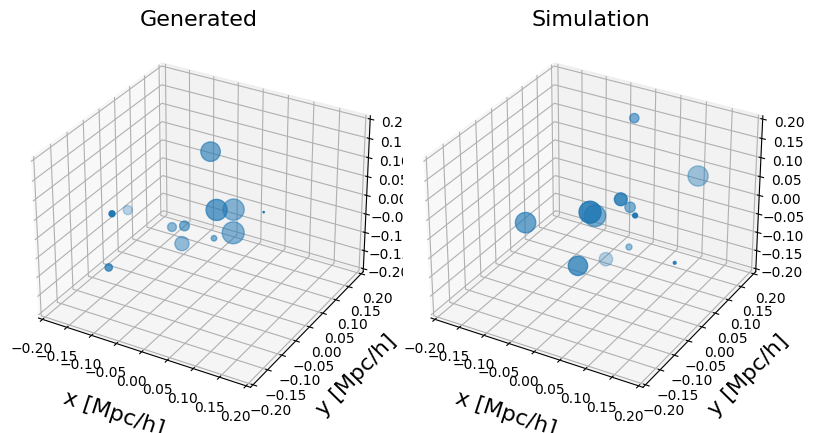

In [16]:
# plot an example satellite
# get the x, y, z coordinates and log_mstar

def scale(x):
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    return (x - x_min) / (x_max - x_min)

# plot example satellites with the size of the points proportional to log_mstar
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# plot the generated samples
example = generated_samples[3]
x, y, z = example[..., 0], example[..., 1], example[..., 2]
log_mstar = example[..., 7]
ax1.scatter(x, y, z, s=scale(log_mstar) * 250)

# plot the simulation counterpart
example = sim_samples[3]
x, y, z = example[..., 0], example[..., 1], example[..., 2]
log_mstar = example[..., 7]
ax2.scatter(x, y, z, s=scale(log_mstar) * 250)

for ax in (ax1, ax2):
    ax.set_xlabel('x [Mpc/h]', fontsize=16, labelpad=10)
    ax.set_ylabel('y [Mpc/h]', fontsize=16, labelpad=10)
    ax.set_zlabel('z [Mpc/h]', fontsize=16, labelpad=10)
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.2, 0.2)
    ax.set_zlim(-0.2, 0.2)
ax1.set_title('Generated', fontsize=16)
ax2.set_title('Simulation', fontsize=16)
fig.tight_layout()
plt.show()

As an example, we plot the generated samples for the satellite mass distribution and stellar-halo mass relation.

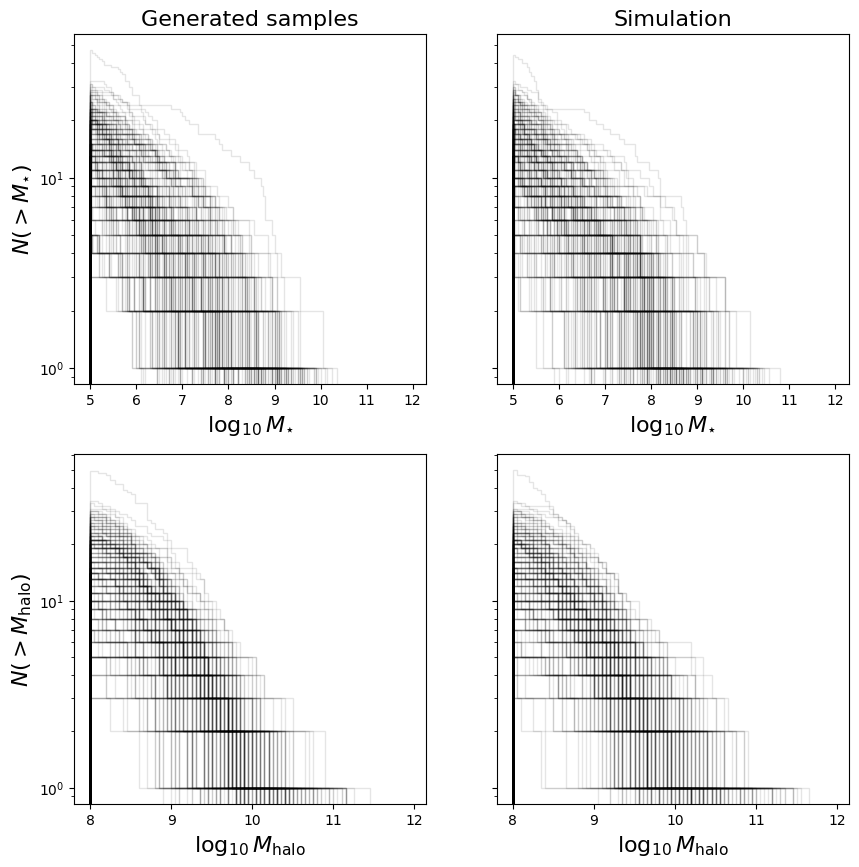

In [17]:
# Plot the satellite stellar and halo mass function
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex='row', sharey='row')

# Plot the mass function
for i in range(len(generated_samples)):
    # stellar mass function
    bins = np.arange(5, 12, 0.05)
    axes[0, 0].hist(
        generated_samples[i, :, 7], histtype='step', 
        bins=bins, color='black', alpha=0.1, cumulative=-1)
    axes[0, 1].hist(
        sim_samples[i, :, 7], histtype='step',
        bins=bins, color='black', alpha=0.1, cumulative=-1)
    
    # halo mass function
    bins = np.arange(8, 12, 0.05)
    axes[1, 0].hist(
        generated_samples[i, :, 6], histtype='step', 
        bins=bins, color='black', alpha=0.1, cumulative=-1)
    axes[1, 1].hist(
        sim_samples[i, :, 6], histtype='step',
        bins=bins, color='black', alpha=0.1, cumulative=-1)

axes[0, 0].set_yscale('log')
axes[1, 0].set_yscale('log')
axes[0, 0].set_title('Generated samples', fontsize=16)
axes[0, 1].set_title('Simulation', fontsize=16)
axes[0, 0].set_xlabel(r'$\log_{10} M_{\star}$', fontsize=16)
axes[0, 1].set_xlabel(r'$\log_{10} M_{\star}$', fontsize=16)
axes[1, 0].set_xlabel(r'$\log_{10} M_\mathrm{halo}$', fontsize=16)
axes[1, 1].set_xlabel(r'$\log_{10} M_\mathrm{halo}$', fontsize=16)
axes[0, 0].set_ylabel(r'$N(>M_{\star})$', fontsize=16)
axes[1, 0].set_ylabel(r'$N(>M_\mathrm{halo})$', fontsize=16)

plt.show()

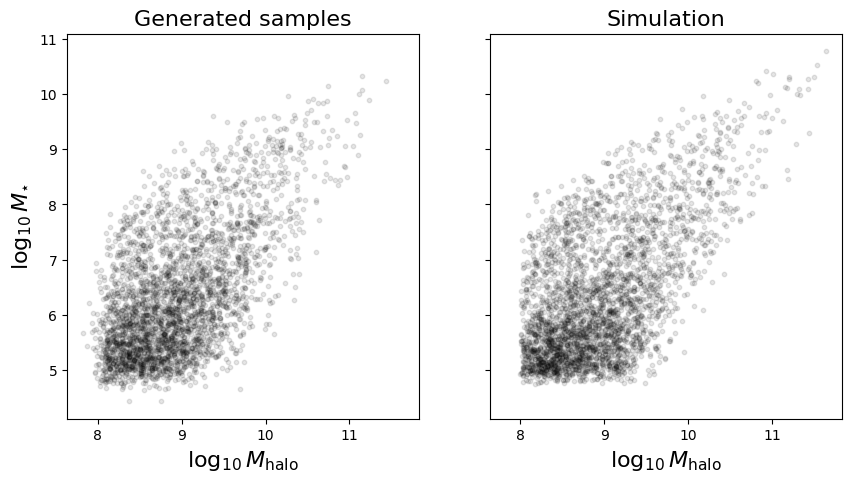

In [18]:
# Plot the satellite stellar and halo mass function
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

# Plot the mass function
for i in range(len(generated_samples)):
    axes[0].scatter(
        generated_samples[i, :, 6], generated_samples[i, :, 7],
        color='black', alpha=0.1, s=10)
    axes[1].scatter(
        sim_samples[i, :, 6], sim_samples[i, :, 7],
        color='black', alpha=0.1, s=10)

axes[0].set_title('Generated samples', fontsize=16)
axes[1].set_title('Simulation', fontsize=16)
axes[0].set_xlabel(r'$\log_{10} M_\mathrm{halo}$', fontsize=16)
axes[1].set_xlabel(r'$\log_{10} M_\mathrm{halo}$', fontsize=16)
axes[0].set_ylabel(r'$\log_{10} M_{\star}$', fontsize=16)

plt.show()

A few notes before we 
- By eyes, it looks like the VDM is able to generate samples that are similar to the training data. More detailed analysis is shown in Notebook 3, where we combine the VDM with normalizing flows to generate samples from just the prior distribution.
- From the mass distributions, it can be seen that the VDM can predict values *below* the cut-off mass, which is $10^8 \, \mathrm{M}_\odot h^{-1}$ and $2 \times 10^5 \, \mathrm{M}_\odot h^{-1}$ for the total and stellar mass.  This occurs because the VDM is designed to model smooth distributions and thus struggles to model sharp cut-offs. Nevertheless, the rapid decline in the number of predicted satellites below the cut-off mass is a reassuring indication that the model accurately captures the distribution near these thresholds.